In [1]:
from numba import jit
import numpy as np
import pandas as pd
import random
import re
from functools import reduce
import math
from math import log
import time
from typing import List, Set, Dict

In [2]:
training_base_df = pd.read_csv("trg.csv")

In [3]:
training_base_df.head()

,id,class,abstract
0,1,B,the 4 202 353 bp genome of the alkaliphilic ba...
1,2,A,the complete 1751377-bp sequence of the genome...
2,3,E,in 1992 we started assembling an ordered libra...
3,4,E,the aim of this study is to measure human mito...
4,5,B,the amino acid sequence of the spirulina maxim...


In [4]:
class CrossValidation():
    def __init__(self, dataframe, num_split=10):
        self.df = dataframe
        self.split = num_split
        self.dfs = self.shuffle_and_split()
    
    def shuffle_and_split(self, random_state=42): # add random state parameter so that it can be replicated
        np.random.seed(42)
        np.random.shuffle(self.df.values) 
        return np.split(self.df, self.split, axis=0) # split the dataset 
    
    def get_ith_cv(self,i):
        i%=self.split
        train = []
        test = self.dfs[i]
        test.reset_index(drop=True, inplace=True)
        for x in range(self.split):
            if x == i:
                continue
            train.append(self.dfs[x])
        train = pd.concat(train, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
        train.reset_index(drop=True, inplace=True)
        return train,test
    
    def train_and_validate(self):
        
        accuracy = np.zeros(self.split, dtype=float)
        for i in range(self.split):
            print("Fold ",i+1)
            train_df, test_df = self.get_ith_cv(i)
            classifier = MultinomialNBC()
            classifier.add_ignored_words(stopwords)
            classifier.train(train_df)
            predictions = classifier.predict(test_df)
            Y_test = test_df["class"]
            accuracy[i] = get_accuracy(Y_test, predictions)
            print(accuracy[i])
        return accuracy
    
            
            
            


In [5]:
crossval_data = CrossValidation(training_base_df)

In [6]:
stopwords = []
with open("english_stopwords.txt", "r") as f:
    stopwords = [i.strip() for i in f.readlines()] # Read the file, strip newlines 

In [7]:
class MultinomialNBC():
    
    def __init__(self):
        self.classes = []
        self.num_class = 0
        self.class_mapping = dict()
        self.reverse_class_mapping = dict()
        self.word_mapping = dict()
        self.reverse_word_mapping = dict()
        self.word_counts = []
        self.probs = []
        self.words = []
        self.num_unique_words = 0
        self.alpha_i = 1
        self.ignored_words = set()
    
    def add_ignored_words(self, words):
        for word in words:
            self.ignored_words.add(word)
    
    def train(self, train_data):
        y = train_data["class"]
        x = train_data["abstract"]
        num_training_data = len(x)
        
        self.classes , self.classes_count = np.unique(y, return_counts=True)
        self.num_class = len(self.classes)
        print("number of classes found in train data:",self.num_class)
        print("classes: ", self.classes)
        for i in range(self.num_class):
            self.class_mapping[self.classes[i]]=i
            self.reverse_class_mapping[i] = self.classes[i]
        
        print("Finished preprocess classes: ", time.perf_counter())
        self.get_overall_word_count(x)
        print("Finished count in overall words: ",time.perf_counter())
        
        print("number of unique words=",self.num_unique_words)
        # print(self.word_counts)
        # self.word_counts_per_category = np.zeros([self.num_class, self.num_unique_words], dtype=int) 
        self.weighted_words= np.zeros([len(x), self.num_unique_words], dtype= float)
        self.words_occurence= np.zeros(self.num_unique_words, dtype= int)
        
        for i in range(num_training_data):
            words, counts = np.unique(self._get_sanitized_wordlist(x[i]), return_counts=True)
#             downweight_ratio = math.sqrt(sum(counts**2))
            
            for j in range(len(words)):
                if words[j] not in self.word_mapping:
                    continue
                word_index = self.word_mapping[words[j]] 
                self.weighted_words[i][word_index]= counts[j]
                self.words_occurence[word_index]+=1
#                 self.weighted_words[i][word_index] /= downweight_ratio

        for i in range(num_training_data):
            for j in range(self.num_unique_words):
                self.weighted_words[i][j] *= log(num_training_data/ self.words_occurence[j])
                            
        self.weighted_words_per_class = np.zeros([self.num_class, self.num_unique_words], dtype=float)
        self.weighted_words_class = np.zeros(self.num_class, dtype=float)
        
        
        for i in range(num_training_data):
            words, counts = np.unique(self._get_sanitized_wordlist(x[i]), return_counts=True)
            for j in range(len(words)):
                if words[j] not in self.word_mapping:
                    continue
                data_class_index = self.class_mapping[y[i]]
                word_index = self.word_mapping[words[j]] 
                self.weighted_words_per_class[data_class_index][word_index]+= self.weighted_words[i][word_index]
        for i in range(self.num_class):
            self.weighted_words_class[i] = sum(self.weighted_words_per_class[data_class_index])
            
                
        self.probs = np.zeros([self.num_class, self.num_unique_words], dtype=float)
        
        print("Finished calculating weighted words: ",time.perf_counter())
        
        
        for i in range(self.num_class):
            for j in range(self.num_unique_words):
                self.probs[i][j] = math.log(self.weighted_words_per_class[i][j] + 1) - \
                    math.log(self.weighted_words_class[i] + self.num_unique_words)
                
        print("Training finished")
        print(time.perf_counter())
        return self.probs
        
    
    def _get_sanitized_wordlist(self, sentence):
        wordlist = [x.strip().lower() for x in sentence.split(' ')] # split by space then make it lowercase
        for i in range(len(wordlist)):
            wordlist[i] = re.sub('[^a-z]+', '', wordlist[i]) # Remove everything that is not related to alphabet
        return wordlist
    
    def _construct_word_dictionary(self, sentence, word_dict= {}):
        wordlist = self._get_sanitized_wordlist(sentence)
        for word in wordlist:
            if word in self.ignored_words:
                continue
            if word in word_dict:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
        return word_dict
        
    
    def get_overall_word_count(self, data):
        word_dict = dict()
        
        for abstract in data:
            word_dict = self._construct_word_dictionary(abstract, word_dict= word_dict)
#         print(word_dict)
            
        self.word_counts = np.zeros(len(word_dict), dtype =int)
        self.words = word_dict.keys()
        
        for key,value in word_dict.items():
            self.word_mapping[key] = self.num_unique_words
            self.reverse_word_mapping[self.num_unique_words] = key
            self.word_counts[self.num_unique_words] = value
            self.num_unique_words+=1
            
    
    def predict(self, test_data):        
        x = test_data["abstract"]
        prediction_probs = np.zeros([len(x), self.num_class], dtype=float)
        for i in range(len(x)):
            words, counts = np.unique(self._get_sanitized_wordlist(x[i]), return_counts=True)
            sigma_fi_fact = log(math.factorial(sum(counts)))
            pi_fi_fact = 0
            for k in range(len(words)): 
                pi_fi_fact+= log(math.factorial(counts[k]))
            
            for j in range(self.num_class):
                prediction_probs[i][j] = sigma_fi_fact - pi_fi_fact
                for k in range(len(words)):
                    if words[k] not in self.word_mapping:
                        continue
                    word_index = self.word_mapping[words[k]]
                    prediction_probs[i][j]+= self.probs[j][word_index] * counts[k]
                    
        predictions = [''] * len(x)
        for i in range(len(x)):
            prediction_i = np.argmax(prediction_probs[i], axis=0)
            predictions[i] = self.reverse_class_mapping[prediction_i]
        return predictions
 

In [8]:
train_df, test_df = crossval_data.get_ith_cv(1)
print(len(train_df), len(test_df))

3600 400


In [9]:
classifier = MultinomialNBC()
classifier.add_ignored_words(stopwords)

In [10]:
probs = classifier.train(train_df)

number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  18.1032887
Finished count in overall words:  18.958133
number of unique words= 23510
Finished calculating weighted words:  109.5341432
Training finished
109.680821


In [11]:
predictions = classifier.predict(test_df)
Y_test = test_df["class"]


In [12]:
def get_accuracy(test, predictions):
    correct = 0 
    false = 0 
    for i in range(len(test)):
        if test[i]==predictions[i]:
            correct+=1
        else:
            false+=1
    return correct/(correct+false)

In [13]:
get_accuracy(Y_test, predictions)

0.855

In [14]:
overall_accuracy = crossval_data.train_and_validate()

Fold  1
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  110.1394555
Finished count in overall words:  110.9852717
number of unique words= 23529
Finished calculating weighted words:  199.754211
Training finished
199.9035227
0.8875
Fold  2
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  200.3795227
Finished count in overall words:  201.2492042
number of unique words= 23510
Finished calculating weighted words:  290.5012937
Training finished
290.6522814
0.855
Fold  3
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  291.1054051
Finished count in overall words:  291.9624216
number of unique words= 23534
Finished calculating weighted words:  379.461456
Training finished
379.6130985
0.91
Fold  4
number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  380.0859377
Finished count in overall words:  380.93

In [15]:
overall_accuracy

array([0.8875, 0.855 , 0.91  , 0.86  , 0.87  , 0.91  , 0.885 , 0.8875,
       0.9025, 0.8875])

In [16]:
sum(overall_accuracy)/len(overall_accuracy)

0.8854999999999998

# Get the final model

In [17]:
classifier = MultinomialNBC()
classifier.train(training_base_df)

number of classes found in train data: 4
classes:  ['A' 'B' 'E' 'V']
Finished preprocess classes:  1299.749177
Finished count in overall words:  1300.7120938
number of unique words= 25069
Finished calculating weighted words:  1408.063954
Training finished
1408.221815


array([[-12.5866266 ,  -8.47679837,  -8.97433232, ..., -13.43581626,
        -13.43581626, -13.43581626],
       [-10.75384616,  -6.50416125,  -6.34605343, ..., -13.43581626,
        -13.43581626, -13.43581626],
       [-10.46016034,  -6.21807359,  -6.72169252, ..., -11.20644189,
        -11.20644189, -11.20644189],
       [-12.58598492,  -8.71082866,  -9.90364851, ..., -13.43581626,
        -13.43581626, -13.43581626]])

In [18]:
# Sanity check 
predictions = classifier.predict(test_df)
Y_test = test_df["class"]
get_accuracy(Y_test, predictions)

0.9

In [19]:
test_base_df = pd.read_csv("tst.csv")

In [20]:
test_base_predictions = classifier.predict(test_base_df)
test_base_predictions

['B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'B',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'B',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'B',
 'B',
 'B',
 'B',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'B',
 'B',
 'E',
 'B',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'B',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'B',
 'E',
 'E',
 'E',
 'E',
 'B',
 'B',
 'E',
 'E',
 'E'

In [21]:
answers = pd.DataFrame(list(zip( list(range(1,len(test_base_predictions)+1)) ,test_base_predictions)), columns=['id','class'])
answers

,id,class
0,1,B
1,2,E
2,3,E
3,4,E
4,5,E
...,...,...
995,996,B
996,997,E
997,998,E
998,999,B


In [22]:
df.to_csv ('answers2.csv', index = False, header=True)

In [23]:
import scikitplot as skplt # used only for verifying results 

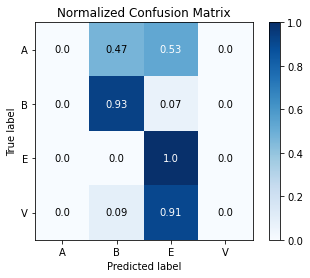

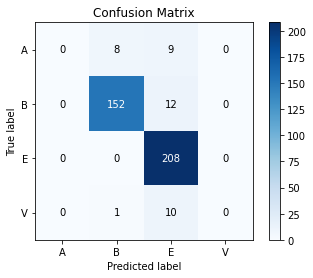

In [24]:
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=True)
skplt.metrics.plot_confusion_matrix(Y_test, predictions, normalize=False)